# Measuring Opioid Stigma Using the Twitter API and NLP

## Introduction
More than 100 Americans each day die from [opioid overdoses](https://www.cdc.gov/drugoverdose/epidemic/index.html). Expanding access to [medication assisted treatment (MAT)](http://adai.uw.edu/pubs/infobriefs/MAT.pdf) has the potential to help reverse the epidemic. However, [efforts to expand MAT have been blocked due to a stigmatized view of opioid addiction](https://www.vox.com/science-and-health/2017/7/20/15937896/medication-assisted-treatment-methadone-buprenorphine-naltrexone) as a moral failing rather than a medical condition.

Despite its importance, very little data is available on opioid-related stigma. This is in part because stigma is difficult to measure with traditional tools such as surveys, which may underestimate the pervasiveness of stigma due to [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias).

A potentially valuable source of data to fill this gap is unstructured text data from Twitter, which is [less likely to suffer from social desirability bias](http://journals.sagepub.com/doi/abs/10.1177/0049124115605339) than traditional surveys.

In order to tap into this data source, we can set up a listener that uses Twitter's [Streaming API](https://developer.twitter.com/en/docs/tweets/filter-realtime/overview) to track opioid-related tweets.

## Data Aquisition

### Scraping Twitter

In [ ]:
import logging
import tweepy
import dataset
from sqlalchemy.exc import ProgrammingError
from requests.packages.urllib3.exceptions import ReadTimeoutError
from textblob import TextBlob
import settings

logging.basicConfig(
    filename=f"logs/{__name__}.log",
    level=logging.DEBUG,
    format="%(name)s - %(asctime)s - %(levelname)s - %(message)s",
    filemode='w')
logger = logging.getLogger()
logger.info('Starting log...')

db = dataset.connect(settings.CONNECTION_STRING)


class StreamListener(tweepy.StreamListener):

    def on_status(self, status):
        if hasattr(status, 'retweeted_status'):
            return

        else:
            try:
                text = status.extended_tweet['full_text']
            except AttributeError:
                text = status.text
            created_utc = status.created_at
            favs = status.favorite_count
            followers = status.user.followers_count
            handle = status.user.screen_name
            loc = status.user.location
            rts = status.retweet_count
            tweet_id_str = status.id_str
            user_id_str = status.user.id_str

            blob = TextBlob(text)
            polarity = blob.sentiment.polarity
            subjectivity = blob.sentiment.subjectivity

            table = db[settings.TABLE_NAME]
            try:
                table.insert(dict(
                    tweet_id=tweet_id_str,
                    user_id=user_id_str,
                    handle=handle,
                    user_location=loc,
                    followers=followers,
                    text=text,
                    created_utc=created_utc,
                    favorites=favs,
                    retweets=rts,
                    polarity=polarity,
                    subjectivity=subjectivity,
                ))
            except ProgrammingError as err:
                logging.warning(err)

    def on_error(self, status_code):
        if status_code == 420:  # rate limiting
            return False


if __name__ == '__main__':
    # Authenticate using tokens defined in settings.py
    auth = tweepy.OAuthHandler(settings.TWITTER_APP_KEY,
                               settings.TWITTER_APP_SECRET)
    auth.set_access_token(settings.TWITTER_KEY, settings.TWITTER_SECRET)
    api = tweepy.API(auth)

    while True:
        try:
            stream_listener = StreamListener()
            stream = tweepy.Stream(auth=api.auth, listener=stream_listener,
                                   tweet_mode='extended')
            stream.filter(track=settings.TRACK_TERMS, languages=['en'],
                          stall_warnings=True)
        except ReadTimeoutError as err:
            logging.warning(err)
            continue


## Data Cleaning

### Load dataset

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import settings

conn = psycopg2.connect(settings.PSYCOPG2_CONNECTION)
df_all = pd.read_sql('select * from {}'.format(settings.TABLE_NAME), con=conn)

df_all.shape

(219136, 10)

### Restrict to tweets with identifiable US location

In [2]:
def clean_location(df):
    """Remove tweets where user does not have comma-separated location"""
    # Calculate total tweets and percent with location
    tweets_total = len(df)   
    with_location = len(df.loc[df['user_location'].notnull()])
    pct_with_location = with_location / tweets_total * 100
    
    # Keep only tweets with user_locations
    df = df.loc[df['user_location'].notnull()]
    
    # Count subset of tweets with location that include comma
    with_location_comma = len(df.loc[df['user_location'].str.contains(",", na=False)])
    pct_with_location_comma = with_location_comma / with_location * 100
    
    print(
        "Tweets with user location: {0} ({1:.0f}% of all tweets)\n"
        "Tweets with comma in user location: {2} ({3:.0f}% of tweets with location)".format(
            with_location, pct_with_location, with_location_comma, pct_with_location_comma)
    )
    
    # Keep only tweets where user_location contains a comma
    return df.loc[df['user_location'].str.contains(",")]

df_geo = clean_location(df_all)

Tweets with user location: 173845 (79% of all tweets)
Tweets with comma in user location: 110754 (64% of tweets with location)


In [3]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [4]:
# Split user location on first two commas
df_geo['user_location1'], df_geo['user_location2'], df_geo['user_location3'] = df_geo['user_location'].str.split(',', 2).str

# Remove leading and trailing whitespace
df_geo.user_location1 = df_geo.user_location1.str.strip()
df_geo.user_location2 = df_geo.user_location2.str.strip()

def capitalize_location(location):
    """Capitalize proper nouns and convert abbreviations to uppercase"""
    if location == None or not(isinstance(location, str)):
        return location
    elif len(location) <= 3:
        return location.upper()
    else:
        return location.title()
        
df_geo['user_location1'] = df_geo['user_location1'].apply(capitalize_location)
df_geo['user_location2'] = df_geo['user_location2'].apply(capitalize_location)

# Create new column containing state, which is user_location2 in most cases
df_geo['state'] = df_geo['user_location2']

# One exception is when user_location2 is "USA". In these cases, user_location1 is usually a state name
df_geo.loc[df_geo.state == 'USA', 'state'] = df_geo.user_location1

# Ensure that all states are represented by their postal abbreviations
df_geo = df_geo.replace({'state': us_state_abbrev})
df_geo.rename(columns={'state': 'state_abbrev'}, inplace=True)

df_geo[['user_location', 'user_location1', 'user_location2', 'state_abbrev']].head()

,user_location,user_location1,user_location2,state_abbrev
1,"Pullman, WA",Pullman,WA,WA
2,"Connecticut, USA",Connecticut,USA,CT
3,"Birmingham, AL",Birmingham,AL,AL
4,"Columbia, Maryland",Columbia,Maryland,MD
6,"Kent, OH",Kent,OH,OH


In [5]:
def keep_usa(df):
    """Keep only rows where state is a U.S. postal abbreviation"""
    tweets_initial = len(df)
    
    tweets_usa = sum(df['state_abbrev'].isin(us_state_abbrev.values()))
    pct_usa = tweets_usa / tweets_initial * 100
    
    print(
        "Tweets with clean USA location: {0} ({1:.0f}% of tweets with comma-separated location)".format(
            tweets_usa, pct_usa)
    )
    
    return df.loc[df['state_abbrev'].isin(us_state_abbrev.values())]

df_usa = keep_usa(df_geo)
df_usa[['user_location','state_abbrev']].head()

Tweets with clean USA location: 86598 (78% of tweets with comma-separated location)


,user_location,state_abbrev
1,"Pullman, WA",WA
2,"Connecticut, USA",CT
3,"Birmingham, AL",AL
4,"Columbia, Maryland",MD
6,"Kent, OH",OH


### View sample of tweets for keyword groups

In [6]:
from IPython.display import display

# Change maximum display width of columns to see sample of tweets
pd.options.display.max_colwidth = 240

# Keyword groups
generic_opioid_keywords = 'opiate|opioid|opium'
other_opioid_keywords = 'codine|hydrocodone|morphine|opana|oxycodone|oxycontin|percocet|vicodin'
other_synthetic_keywords = 'carfentanil|fentanyl'

def keyword_sample(keywords,size=10):
    """Select sample of tweets containing specified keywords."""
    df_temp = df_usa.loc[df_usa['text'].str.contains(keywords, na=False)]
    return df_temp[['handle','user_location','text']].sample(n=size)

generic_opioid_sample = keyword_sample(generic_opioid_keywords,5)
print('Generic Opioid Sample:')
display(generic_opioid_sample)

heroin_sample = keyword_sample('heroin',5)
print('Heroin Sample:')
display(heroin_sample)

other_opioid_sample = keyword_sample(other_opioid_keywords,5)
print('Other Opioid Sample:')
display(other_opioid_sample)

methadone_sample = keyword_sample('methadone',5)
print('Methadone Sample:')
display(methadone_sample)

other_synthetic_sample = keyword_sample(other_synthetic_keywords,5)
print('Other Synthetic Sample:')
display(other_synthetic_sample)

Generic Opioid Sample:


,handle,user_location,text
123487,keepkidsecure,"Texas, USA",NPHC- Nutra Pharma corp. I am 100% disabled Veteran- i know pain and Opiates- this new product woks and safe wow I believe this could be the solution to the opiate crisis- rumor- would be great in combat situations - https://t.co/gj7shy...
110919,drug_knowledge,"Wernersville, PA",HCA chronic opioid attestation form update https://t.co/2row5ZanAQ
214569,JeffreyHanley,"Tempe, AZ","The @nfl needs to stop with this. If he was hooked on prescribed Vicodin or other opioids it would be no problem, but weed? Suspended. https://t.co/BF2GYJrFrJ"
44564,AmidaCareNY,"New York, NY","Op-Ed by Christy Parque, CEO @TheCoalitionNY &amp; Lauri Cole, Executive Director of NYS Council for Community Behavioral Healthcare on the need to build on the momentum created by the #Opioid Stewardship Fund in combating the #opioidep..."
9340,DerekBrandtDC,"Silver Spring, MD","Great recap of the recent #AANAdvocacy wins in the #Omnibus, plus a great article from @wvheadachedoc on the opioid crisis in West Virginia. Check it out! https://t.co/4TIRetm7jM https://t.co/RkXiomYLPt"


Heroin Sample:


,handle,user_location,text
22587,RFenity,"Killeen, TX","@mmsERRN @Goss30Goss @Crypto_Clay @GrendelYmer @MoviesRWin So, how does one regulate and enforce Tom selling his AR15 to Steve for rent money in a parking lot? And, if that were effective, why not apply it to the sell of heroin?"
75676,lmusic6372,"Santa Monica, CA","Couple busted for allegedly running brothel out of home, with kids inside, to fund heroin addiction\n\nhttps://t.co/MoYY73EHc5"
96748,TheBeeAZ,"Bullhead City, AZ",Mohave Valley man arrested in Kingman for alleged heroin sales. Read more: https://t.co/Bkv9ZyyVIe\n\n#thebee #crimewatch #heroinsales #arrest #kpd https://t.co/OkAwGbqEAB
38981,IrishWolverine1,"Muskegon, MI",@MLive I think most a whole lot of people know someone who has died from heroin. This is about time.
19263,DrugTestNews,"Boca Raton, FL",DRUGGED UP The 5 most addictive substances on Earth - and booze ranks HIGHER than heroin https://t.co/i3tSXnMGpz


Other Opioid Sample:


,handle,user_location,text
166286,Marley_Zepeda,"Bakersfield, CA",My mouth hurts me so much. I already took one hydrocodone but it’s not doing much. Getting your wisdom teeth extracted is no joke
5391,diannaeanderson,"Minneapolis, MN","*stares*\n\nUm, my mom was on morphine while in palliative care until she passed. https://t.co/DV0vnpJZd8"
126992,kretschmer_e,"Ventura, CA",It’s a fact the GOP governor Bevin was snorting oxycodone and was hallucinating during the Kentucky teachers strike. https://t.co/AZForU2bfI
152565,graccenicole_,"Camp Lejuene, NC",they prescribed me percocet for post-surgery and the only thing that went through my mind was the song Mask Off 🙃
63922,charminggirl666,"Portland, OR",doctors are like oh no i don’t feel comfortable writing you a note for days that you couldn’t go to work but here’s a prescription for 90 vicodin


Methadone Sample:


,handle,user_location,text
115027,TotalHealthCent,"Virginia Beach, VA",EDDP urine test (methadone) - NarcoCheck https://t.co/ruPBQmNOxQ
75850,TreatFaculty,"Dover, DE","Applicant is in drug treatment, on methadone: Do you have to hire him? https://t.co/VFIZIGnBWd"
101369,diamonddetox,"Elk Grove, CA","🔹🔷 The Top 9 Reasons to Consider Methadone Maintenance Treatment\n\n if you have any additional questions, call to speak to a treatment specialist and start your recovery: (916) 432-5027\n#methadonemaintenance #methadonetreatment #diamo..."
156345,openaidalliance,"Missoula, MT","""Medications like methadone and buprenorphine are prescribed to assist with physiological dependence, which prevents them from getting... https://t.co/GxlUk63f9f"
29879,Offdrugs4ever,"Ocala, FL","methadone Archives - WPSD Local 6 - Your News, Weather, &amp; Sports Authority https://t.co/2NHnp2bWJU"


Other Synthetic Sample:


,handle,user_location,text
140306,harrisburgers,"Harrisburg, PA","#TechTopics: 26 charged in Carlisle heroin, fentanyl probe\n\n#carlisle #cumberlandcounty #cumberland #countyseat #pennsylvania\n\nhttps://t.co/Xd01bNb5fK"
14988,DominicWhitehe9,"Peoria Heights, IL","Prince died from sky-high levels of fentanyl, report shows https://t.co/TSUCnsGRgZ"
170375,TopAtlantaNow,"Atlanta, GA","MINNEAPOLIS (AP) -- Carver County attorney says evidence shows Prince thought he was taking Vicodin, not fentanyl. fox5atl https://t.co/HkHn0yosaz"
196033,tspedwards,"Asheville, North Carolina","Arrests: 5-plus ounces of heroin/fentanyl, 200-grams of ecstasy, and 101 doses of LSD https://t.co/qrKWIpMXG9 https://t.co/AnmlD4zfuO"
44930,IFitz3,"Providence, RI",@MassAGO Interesting how an AG puts foreign nationals and fentanyl dealers ahead of American citizens


## Analysis

### Count Tweets By State

In [7]:
# Remove tweets from bot account with Nebraska location
print("Percent of Nebraska tweets from @nopioids: " +
      str(format((len(df_usa.loc[df_usa['handle'] == 'Nopioids']) /
      len(df_usa.loc[df_usa['state_abbrev'] == 'NE'])) * 100, '.2f')))

df_usa = df_usa.loc[df_usa['handle'] != 'Nopioids']

Percent of Nebraska tweets from @nopioids: 81.19


In [8]:
def count_by_keyword_state(keywords,group_name):
    """Count tweets containing keyword groups by state"""
    df_temp = df_usa.loc[df_usa['text'].str.contains(keywords, na=False)]
    return df_temp.groupby('state_abbrev').size().reset_index(name='{}_tweets'.format(group_name))

generic_opioid_by_state = count_by_keyword_state(generic_opioid_keywords,'generic_opioid')
heroin_by_state = count_by_keyword_state('heroin','heroin')
other_opioid_by_state = count_by_keyword_state(other_opioid_keywords,'other_opioid')
methadone_by_state = count_by_keyword_state('methadone','methadone')
other_synthetic_by_state = count_by_keyword_state(other_synthetic_keywords,'other_synthetic')

# Merge
tweets_by_state = generic_opioid_by_state.merge(heroin_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(other_opioid_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(methadone_by_state,how='left',on='state_abbrev',validate='1:1')
tweets_by_state = tweets_by_state.merge(other_synthetic_by_state,how='left',on='state_abbrev',validate='1:1')

# Calculate total tweets
tweets_by_state['total_tweets'] = tweets_by_state.sum(axis=1)

tweets_by_state.head()

,state_abbrev,generic_opioid_tweets,heroin_tweets,other_opioid_tweets,methadone_tweets,other_synthetic_tweets,total_tweets
0,AK,36,33,4,1.0,7.0,81.0
1,AL,233,71,14,35.0,41.0,394.0
2,AR,167,20,9,NaN,22.0,218.0
3,AZ,359,130,32,8.0,54.0,583.0
4,CA,2020,751,185,48.0,313.0,3317.0


### Load and merge overdose data from CDC

In [9]:
# Import state opioid overdose totals from CDC
# https://wonder.cdc.gov/mcd-icd10.html
od_by_state_ucd = pd.read_csv('../data/cdc_wonder/state_opioid_od_total_2016.txt',
                          sep='\t', usecols=[*range(0,4),*range(5,9),*range(11,13)], 
                          skipfooter=72, engine='python')

# Keep only totals
od_by_state_ucd = od_by_state_ucd.loc[(od_by_state_ucd['Notes']=='Total') & 
                               (od_by_state_ucd['Year'].notna())]
od_by_state_ucd = od_by_state_ucd[od_by_state_ucd.columns.drop(od_by_state_ucd.filter(regex='Cause').columns)]
od_by_state_ucd = od_by_state_ucd.drop(columns=['Notes'])

# Clean column headers
od_by_state_ucd.rename(columns={'Deaths': 'deaths_total', 
                             'Age Adjusted Rate': 'adjusted_rate_total',
                             'Age Adjusted Rate Standard Error': 'adjusted_rate_se_total'}, inplace=True)

od_by_state_ucd.head()

,State,State Code,Year,deaths_total,Population,adjusted_rate_total,adjusted_rate_se_total
2,Alabama,1,2016.0,343,4863300,7.5,0.4
6,Alaska,2,2016.0,94,741894,12.5,1.3
13,Arizona,4,2016.0,769,6931071,11.4,0.4
20,Arkansas,5,2016.0,169,2988248,5.9,0.5
29,California,6,2016.0,2012,39250017,4.9,0.1


In [10]:
# Import state opioid overdose by drug type from CDC
# Note: Some deaths involve multiple drug types which is why these sum to more than the total
od_by_state_mcd = pd.read_csv('../data/cdc_wonder/state_opioid_od_substance_2016.txt',
                           sep='\t', usecols=[*range(1,4),*range(5,9),*range(11,13)],
                           skipfooter=74, engine='python')

# Keep only heroin
od_by_state_mcd = od_by_state_mcd.loc[od_by_state_mcd['Multiple Cause of death']=='Heroin']
od_by_state_mcd = od_by_state_mcd[od_by_state_mcd.columns.drop(od_by_state_mcd.filter(regex='Cause').columns)]

# Clean column headers
od_by_state_mcd.rename(columns={'Deaths': 'deaths_heroin', 
                             'Age Adjusted Rate': 'adjusted_rate_heroin',
                             'Age Adjusted Rate Standard Error': 'adjusted_rate_se_heroin'}, inplace=True)

od_by_state_mcd.head()

,State,State Code,Year,deaths_heroin,Population,adjusted_rate_heroin,adjusted_rate_se_heroin
0,Alabama,1,2016,126,4863300,2.8,0.3
5,Alaska,2,2016,49,741894,6.5,0.9
9,Arizona,4,2016,299,6931071,4.5,0.3
14,Arkansas,5,2016,13,2988248,Unreliable,0.1
19,California,6,2016,587,39250017,1.4,0.1


In [11]:
# Left merge since heroin data is missing for Montana, Nebraska, South Dakota, and Wyoming
od_by_state = od_by_state_ucd.merge(od_by_state_mcd,how='left',on=['State','State Code','Year','Population'],validate='1:1')

# Clean column headers
od_by_state.columns = map(str.lower, od_by_state.columns)
od_by_state.rename(columns={'state': 'state_name', 'state code': 'fips'}, inplace=True)
od_by_state['state_abbrev'] = od_by_state['state_name'].map(us_state_abbrev)
cols = od_by_state.columns.tolist()
cols= cols[-1:] + cols[0:-1]
od_by_state = od_by_state[cols]

od_by_state.head()

,state_abbrev,state_name,fips,year,deaths_total,population,adjusted_rate_total,adjusted_rate_se_total,deaths_heroin,adjusted_rate_heroin,adjusted_rate_se_heroin
0,AL,Alabama,1,2016,343,4863300,7.5,0.4,126.0,2.8,0.3
1,AK,Alaska,2,2016,94,741894,12.5,1.3,49.0,6.5,0.9
2,AZ,Arizona,4,2016,769,6931071,11.4,0.4,299.0,4.5,0.3
3,AR,Arkansas,5,2016,169,2988248,5.9,0.5,13.0,Unreliable,0.1
4,CA,California,6,2016,2012,39250017,4.9,0.1,587.0,1.4,0.1


In [12]:
# Merge with tweets_by_state
od_tweets_by_state = od_by_state.merge(tweets_by_state,on='state_abbrev',validate='1:1')

od_tweets_by_state['total_tweets_per_100k'] = ((od_tweets_by_state['total_tweets'] 
                                               / od_tweets_by_state['population']) * 10**5)

def calc_pct(df,numerator,denominator):
    """Calculate contribution of each keyword group to total"""
    return (df[numerator].divide(df[denominator], fill_value=0) * 100).round(1)

od_tweets_by_state['pct_generic_tweets'] = calc_pct(od_tweets_by_state,'generic_opioid_tweets','total_tweets')
od_tweets_by_state['pct_heroin_tweets'] = calc_pct(od_tweets_by_state,'heroin_tweets','total_tweets')
od_tweets_by_state['pct_rx_tweets'] = calc_pct(od_tweets_by_state,'other_opioid_tweets','total_tweets')
od_tweets_by_state['pct_methadone_tweets'] = calc_pct(od_tweets_by_state,'methadone_tweets','total_tweets')
od_tweets_by_state['pct_fentanyl_tweets'] = calc_pct(od_tweets_by_state,'other_synthetic_tweets','total_tweets')

od_tweets_by_state.head()

,state_abbrev,state_name,fips,year,deaths_total,population,adjusted_rate_total,adjusted_rate_se_total,deaths_heroin,adjusted_rate_heroin,...,other_opioid_tweets,methadone_tweets,other_synthetic_tweets,total_tweets,total_tweets_per_100k,pct_generic_tweets,pct_heroin_tweets,pct_rx_tweets,pct_methadone_tweets,pct_fentanyl_tweets
0,AL,Alabama,1,2016,343,4863300,7.5,0.4,126.0,2.8,...,14,35.0,41.0,394.0,8.101495,59.1,18.0,3.6,8.9,10.4
1,AK,Alaska,2,2016,94,741894,12.5,1.3,49.0,6.5,...,4,1.0,7.0,81.0,10.918002,44.4,40.7,4.9,1.2,8.6
2,AZ,Arizona,4,2016,769,6931071,11.4,0.4,299.0,4.5,...,32,8.0,54.0,583.0,8.411398,61.6,22.3,5.5,1.4,9.3
3,AR,Arkansas,5,2016,169,2988248,5.9,0.5,13.0,Unreliable,...,9,NaN,22.0,218.0,7.295245,76.6,9.2,4.1,0.0,10.1
4,CA,California,6,2016,2012,39250017,4.9,0.1,587.0,1.4,...,185,48.0,313.0,3317.0,8.450952,60.9,22.6,5.6,1.4,9.4


### Figure 1: Visualization of Tweets per State with Breakdown by Drug Type

In [13]:
import plotly.plotly as py
scl = [[0.0, 'rgb(242,240,247)'], [0.2, 'rgb(218,218,235)'], [0.4, 'rgb(188,189,220)'],
       [0.6, 'rgb(158,154,200)'], [0.8, 'rgb(117,107,177)'], [1.0, 'rgb(84,39,143)']]

od_tweets_by_state['text'] = '<br>' + od_tweets_by_state['state_name'] + '<br>' + '<br>' +\
            'Opioid/Opiate/Opium: ' + od_tweets_by_state['pct_generic_tweets'].astype(str) + '%' + '<br>' +\
            'Heroin: ' + od_tweets_by_state['pct_heroin_tweets'].astype(str) + '%' + '<br>' +\
            'Prescription Opioids: ' + od_tweets_by_state['pct_rx_tweets'].astype(str) + '%' + '<br>' +\
            'Fentanyl/Carfentanil: ' + od_tweets_by_state['pct_fentanyl_tweets'].astype(str) + '%' + '<br>' +\
            'Methadone: ' + od_tweets_by_state['pct_methadone_tweets'].astype(str) + '%'
            
data = [dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = od_tweets_by_state['state_abbrev'],
            z = od_tweets_by_state['total_tweets_per_100k'].round(2),
            locationmode = 'USA-states',
            text = od_tweets_by_state['text'],
            marker = dict(
                line = dict(
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Tweets per 100,000")
            )
        ]

layout = dict(
            title = '<b>Opioid-Related Tweets Per 100k</b><br>' + \
                    '(Hover for Breakdown of Opioid-Related Tweets)',
            geo = dict(
                scope='usa',
                projection=dict(type='albers usa'),
                showlakes = True,
                lakecolor = 'rgb(255, 255, 255)'
            )
        )
    
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='state-cloropleth-tweets')

### Figure 2: Relationship between Tweet Frequency and Overdose Deaths

Text(0,0.5,'Opioid Related Tweets (Per 100,000)')

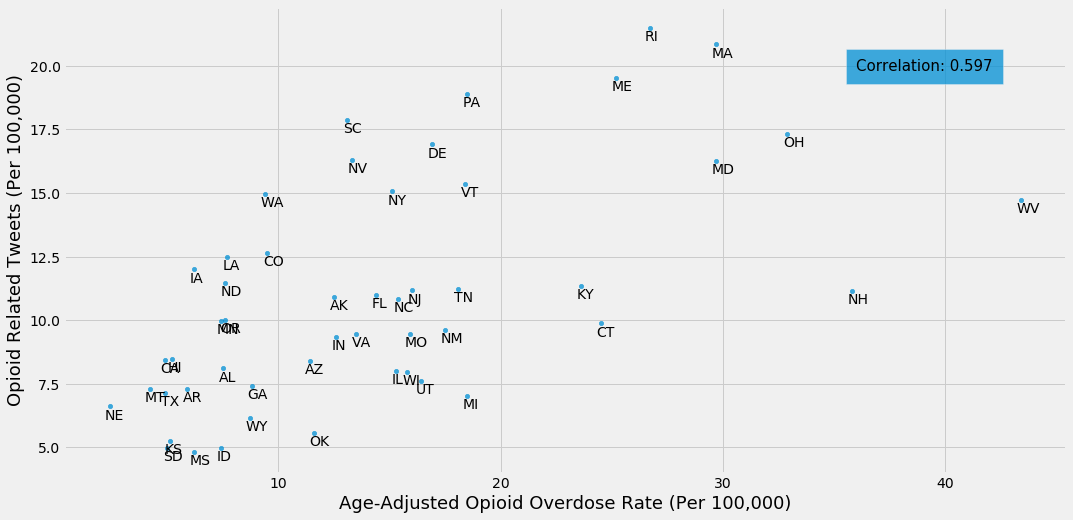

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

x = od_tweets_by_state.adjusted_rate_total.astype(float)
y = od_tweets_by_state.total_tweets_per_100k

plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(x,y, s=20, alpha=0.75)
for i, txt in enumerate(od_tweets_by_state['state_abbrev']):
    ax.annotate(txt, ((x[i]-0.2),(y[i]-0.5)))
    
ax.text(36, 19.8, 'Correlation: {}'.format(format(pearsonr(x, y)[0], '.3f')),
        bbox={'pad':10, 'alpha':0.75}, fontsize=15)
    
ax.set_xlabel('Age-Adjusted Opioid Overdose Rate (Per 100,000)', fontsize=18)
ax.set_ylabel('Opioid Related Tweets (Per 100,000)', fontsize=18)

## Conclusion

This first-stage analysis demonstrates that conversations taking place about opioids on Twitter are correlated with real-world public health outcomes, such as overdose deaths. A quick visual comparison of the choropleth of tweet frequency (Figure 1 above) with [choropleths of overdose death rates](https://www.cdc.gov/drugoverdose/data/statedeaths.html) reveals remarkable similarities. Plotting the relationship between tweet frequency and opioid overdose deaths (Figure 2) confirms that a positive correlation exists between these two indicators.

This is promising for subsequent analyses in which I will look not only at the frequency of these conversations but also their sentiment. Specifically, I plan to next look at measures of polarity and subjectivity before eventually developing a custom sentiment analysis algorithm that codes for stigma.

Other next steps include:
 - Analyzing the relationship between conversations about opioids and access to treatment
 - Analyzing the relationship between conversations that specifically mention treatment and access to treatment
 - Further refining data cleaning procedures to remove suspected bots